In [1]:
library(ggplot2)
library(Hmisc)
source("../utilis/utilis.R")
library(glue)
library(dplyr)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
threshold = 1
cutoff_column = 'pval'
data_df_path =  '../../../output/hMinImp_TICnorm_groupFil0.3_RPneg_1wayANOVA/updPS_sel_one_wayANOVA_hMinImp_TICnorm_groupFil0.3_RPneg_fullreport.csv'
meta_df_path =  '../../../../seq/RPneg_addgrp.csv'

# Prepare the data

## Read and transform the data table and metadata table

In [3]:
PS_df = read.csv(data_df_path)
meta_df = read.csv(meta_df_path)

----

In [4]:
grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(PS_df))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE
[37]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE

In [5]:
data_df = PS_df[grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(PS_df))]

In [6]:
head(data_df)

,CD8TD_750K_1,CD8TD_750K_2,CD8stem_250K_1,CD8stem_300K_2,CD8trans_250K_2,CD8trans_350K_1,Tn_250K_1,Tn_250K_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21.45696,21.28816,19.76150,19.76150,20.70503,19.76150,19.76150,19.76150
2,17.39546,17.39546,17.39546,17.39546,17.39546,17.39546,19.25357,18.43803
3,21.20137,14.23926,20.69847,14.23926,14.23926,14.23926,21.07399,20.94022
4,20.48466,16.32400,18.21367,16.32400,16.32400,16.32400,17.29207,17.36658
5,19.54137,20.67891,21.24867,21.31945,21.63505,21.03447,20.59031,21.42817
6,21.49334,21.47945,21.38956,21.52322,21.56036,21.53672,21.58724,21.40511


----

In [7]:
head(meta_df)

,Sample.Type,File.Name,Sample.ID,Sample_ID_upd,cell_number,group,Comment,Path,Instrument.Method,Process.Method,Position,Inj.Vol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<chr>,<int>
1,Blank,Blank_20230308_002,Blank_20230308_002,Blank_1,NR,Blank,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A1,2
2,Blank,Blank_20230308_004,Blank_20230308_004,Blank_2,NR,Blank,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A1,2
3,Blank,Blank_std_20230308_1_002,Blank_std_20230308_002,Blank_std_1,NR,Blank_std,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A2,2
4,QC,MT_20230308_002,Qstd_20230308_002,Qstd_1,NR,Qstd,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A3,2
5,QC,MT_20230308_004,Qstd_20230308_004,Qstd_2,NR,Qstd,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A3,2
6,Unknown,MT_20230308_006,pooledsample_02,pooled_1,NA,pooled,1,D:\IDX_Data\Maheshwor\20220213_phosphatidylserine\20230308_sample_analysis\HILICpos_RPneg,C:\Xcalibur\methods\MT\phosphatidylserine_tSIM_method\20220322_MT_RPneg_Aria_FS_60Kres_20min_PS,NA,G:A4,5


In [8]:
rownames(meta_df) = meta_df$Sample_ID_upd

----

In [9]:
# lookUpAnnot <- function(annot_df,
#                         FeatureID,
#                         look4column = '') {
#     output = annot_df[annot_df[,'id_number'] == FeatureID,look4column]
#     return(output)
# }

# lookUpAnnot(annot_df,'F8342','Species.Shorthand')

## Transform and merge data

In [10]:
source('../utilis/utilis.R')
transform_merge_data4violin <- function(df = df,
                                 meta_df = meta_df,
                                 class_column = 'group',
                                 cutoff_column = 'padj', 
                                 threshold = threshold) {
    
    df_filt <- df[df[,cutoff_column] < threshold,
              colnames(df)[grepl('(Tn|CD8stem|CD8TD|CD8trans)\\_[0-9]+',colnames(df))]] # 
    df_filt.T <- t(df_filt)
    # print(head(df_filt.T))
    merged_df = merge_by_rowName(meta_df,df_filt.T, all.y = TRUE)
    merged_df[,class_column] = factor(
        merged_df[,class_column],
        level = c('Tn',
                  'CD8stem',
                  'CD8trans',
                  'CD8TD')
    )
    return(merged_df)
}

In [11]:
merged_df <- transform_merge_data4violin(df = PS_df,
                                         meta_df = meta_df,
                                         class_column = 'group',
                                         cutoff_column = 'pval', 
                                         threshold = threshold)

In [12]:
colnames(merged_df)

[1] "Sample.Type"       "File.Name"         "Sample.ID"        
  [4] "Sample_ID_upd"     "cell_number"       "group"            
  [7] "Comment"           "Path"              "Instrument.Method"
 [10] "Process.Method"    "Position"          "Inj.Vol"          
 [13] "1"                 "2"                 "3"                
 [16] "4"                 "5"                 "6"                
 [19] "7"                 "8"                 "9"                
 [22] "10"                "11"                "12"               
 [25] "13"                "14"                "15"               
 [28] "16"                "17"                "18"               
 [31] "19"                "20"                "21"               
 [34] "22"                "23"                "24"               
 [37] "25"                "26"                "27"               
 [40] "28"                "29"                "30"               
 [43] "31"                "32"                "33"               
 [46] "34"                "35"                "36"               
 [49] "37"                "38"                "39"               
 [52] "40"                "41"                "42"               
 [55] "43"                "44"                "45"               
 [58] "46"                "47"                "48"               
 [61] "49"                "50"                "51"               
 [64] "52"                "53"                "54"               
 [67] "55"                "56"                "57"               
 [70] "58"                "59"                "60"               
 [73] "61"                "62"                "63"               
 [76] "64"                "65"                "66"               
 [79] "67"                "68"                "69"               
 [82] "70"                "71"                "72"               
 [85] "73"                "74"                "75"               
 [88] "76"                "77"                "78"               
 [91] "79"                "80"                "81"               
 [94] "82"                "83"                "84"               
 [97] "85"                "86"                "87"               
[100] "88"                "89"                "90"               
[103] "91"                "92"                "93"               
[106] "94"                "95"                "96"               
[109] "97"                "98"                "99"               
[112] "100"               "101"               "102"              
[115] "103"               "104"

# Output directory

In [13]:
output_dir = "../../../output/hMinImp_TICnorm_groupFil0.3_RPneg_1wayANOVA/PS_including_LPS_sum_boxplot_upd/"
dir.create(output_dir)

In [14]:
ncol(meta_df)

[1] 12

In [15]:
merged_df[1:5,ncol(meta_df):ncol(merged_df)]

,Inj.Vol,1,2,3,4,5,6,7,8,9,⋯,95,96,97,98,99,100,101,102,103,104
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD8stem_250K_1,5,19.76150,17.39546,20.69847,18.21367,21.24867,21.38956,19.60386,20.96215,24.64296,⋯,14.61991,18.86615,18.64494,18.00379,22.11797,18.89041,20.93692,20.38200,18.98020,20.14743
CD8stem_300K_2,5,19.76150,17.39546,14.23926,16.32400,21.31945,21.52322,19.18106,19.50436,24.33050,⋯,16.31831,18.94344,18.00630,16.94553,21.67591,18.89696,19.96708,19.71387,18.00940,20.14743
CD8TD_750K_1,5,21.45696,17.39546,21.20137,20.48466,19.54137,21.49334,18.05981,18.38312,25.51364,⋯,16.95737,19.78342,18.73401,18.55580,21.70068,18.00314,17.90540,16.28507,15.88749,21.79929
CD8TD_750K_2,5,21.28816,17.39546,14.23926,16.32400,20.67891,21.47945,18.05981,18.38312,25.58940,⋯,17.95357,19.70054,18.76827,18.12185,21.56471,15.92350,17.90540,16.28507,15.88749,21.89787
CD8trans_250K_2,5,20.70503,17.39546,14.23926,16.32400,21.63505,21.56036,18.05981,18.38312,25.20516,⋯,17.35967,18.49492,18.40411,18.69804,22.07837,19.63125,20.14513,19.99611,18.44877,20.14743


In [31]:
rowsums = rowSums(2^(merged_df[,(ncol(meta_df)+1):ncol(merged_df)]))

In [32]:
merged_df[,3:5]

,Sample.ID,Sample_ID_upd,cell_number
,<chr>,<chr>,<chr>
CD8stem_250K_1,CD8T_stem_250k_01_02,CD8stem_250K_1,250000
CD8stem_300K_2,CD8T_stem_300k_01_02,CD8stem_300K_2,300000
CD8TD_750K_1,CD8T_TD_750k_01_02,CD8TD_750K_1,750000
CD8TD_750K_2,CD8T_TD_750k_01_02,CD8TD_750K_2,750000
CD8trans_250K_2,CD8T_trans_250k_01_02,CD8trans_250K_2,250000
CD8trans_350K_1,CD8T_trans_350k_01_02,CD8trans_350K_1,350000
Tn_250K_1,Naive_250k_01_02,Tn_250K_1,250000
Tn_250K_2,Naive_250k_02_02,Tn_250K_2,250000


In [33]:
PSsum_df = merged_df[,3:7] # 
PSsum_df$PS_sum = rowsums

In [34]:
PSsum_df

,Sample.ID,Sample_ID_upd,cell_number,group,Comment,PS_sum
,<chr>,<chr>,<chr>,<fct>,<int>,<dbl>
CD8stem_250K_1,CD8T_stem_250k_01_02,CD8stem_250K_1,250000,CD8stem,1,556602769
CD8stem_300K_2,CD8T_stem_300k_01_02,CD8stem_300K_2,300000,CD8stem,1,517325981
CD8TD_750K_1,CD8T_TD_750k_01_02,CD8TD_750K_1,750000,CD8TD,1,1002526132
CD8TD_750K_2,CD8T_TD_750k_01_02,CD8TD_750K_2,750000,CD8TD,1,957335357
CD8trans_250K_2,CD8T_trans_250k_01_02,CD8trans_250K_2,250000,CD8trans,1,660845672
CD8trans_350K_1,CD8T_trans_350k_01_02,CD8trans_350K_1,350000,CD8trans,1,584409038
Tn_250K_1,Naive_250k_01_02,Tn_250K_1,250000,Tn,1,452272723
Tn_250K_2,Naive_250k_02_02,Tn_250K_2,250000,Tn,1,472603564


# Wrapper Function: plot a single box plot

In [35]:
box_plot <- function(long_df = merged_df,
                        x = 'group',
                        y = var,
                        xlab = xlab,
                        ylab = ylab,
                        fill_color = 'group',
                        fig_width = 8,
                        fig_height = 8,
                        text_size = 20,
                        legend_size = 20,
                        axis_title_size = 20,
                        output_dir = "",
                        pdf_prefix = 'test',
                        show_plot = TRUE) {
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)

    p <- ggplot(long_df, aes_string(x = x, y = y, fill = fill_color)) + 
        geom_boxplot(outlier.shape = NA) +
        xlab(xlab) + ylab(ylab) + 
        geom_jitter(alpha = 1) +
        scale_fill_manual(values = c("#888888","#0000ff","#FFA500","#ff0000")) +  #

        # set transparency
        # https://ggplot2.tidyverse.org/reference/theme.html
        theme(
          panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
          panel.border = element_rect(fill = NA),
          #panel.grid.minor = element_blank(),
          panel.background = element_rect(fill = "transparent",colour = NA),
          plot.background = element_rect(fill = "transparent",colour = NA),
          axis.text = element_text(size = text_size, colour="black"),
          axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5, colour="black"),
          legend.text= element_text(size = legend_size),
          legend.title = element_text(size = legend_size),
          axis.title = element_text(size = axis_title_size)
        )
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, paste0("ggplot_boxplot_",pdf_prefix,".pdf")), width = fig_width, height = fig_height)
        }
}

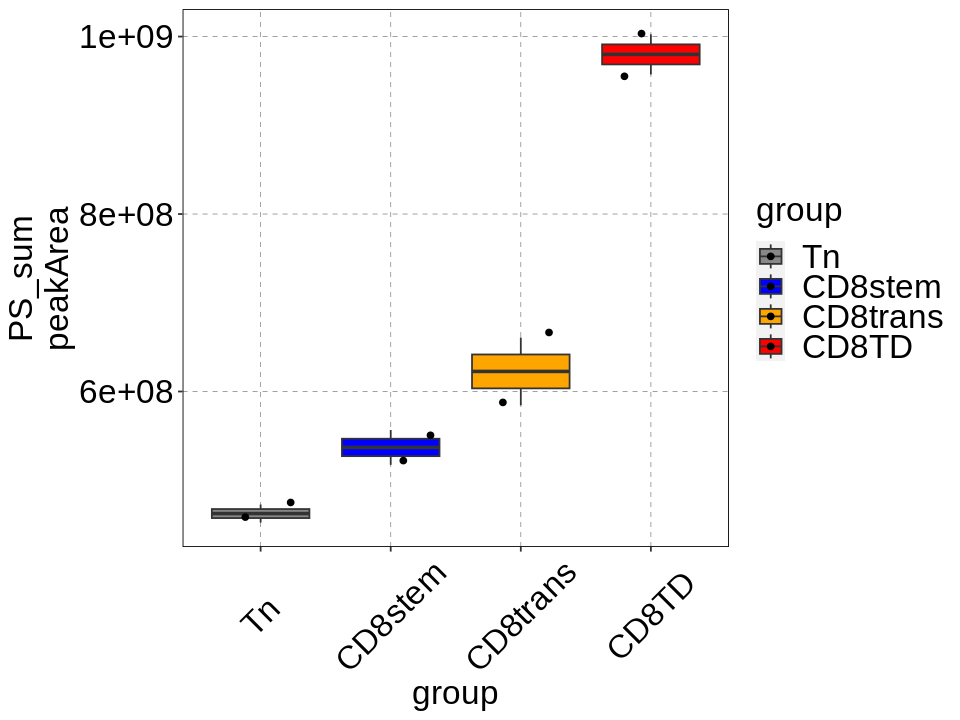

In [37]:
var = 'PS_sum'
box_plot(long_df = PSsum_df,
            x = 'group',
            y = var,
            xlab = 'group',
            ylab = glue('{var}\npeakArea'),
            fill_color = 'group',
            fig_width = 8,
            fig_height = 6,
            text_size = 20,
            legend_size = 20,
            axis_title_size = 20,
            output_dir = output_dir,
            pdf_prefix = 'PS_sum_RPneg')